In [1]:
import os
import pathlib
from pathlib import Path
import re

import pandas as pd
import numpy as np

In [87]:
workdir='CNN_single_task_grid'
os.chdir('/users/qdb16186')
path=os.getcwd()
abs_dir=path+"/"+workdir

# Bash_script

In [11]:
def bash_script_gen(abs_dir):
    dir=abs_dir
    cores=15
    HH=48
    job_name="CNN_single_task_Granulated_15_cores"
    python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/sbatch_.sh','w') as f:
        f.write(f"""#!/bin/bash

#======================================================
#
# Job script for running on a single node
#
#======================================================

#======================================================
# Propogate environment variables to the compute node
#SBATCH --export=ALL
#
# Run in the standard partition (queue)
#SBATCH --partition=standard
#
# Specify project account
#SBATCH --account=palmer-addmd
#
# No. of tasks required
#SBATCH --ntasks=1 --cpus-per-task={cores}
#
# Distribute processes in round-robin fashion for load balancing
#SBATCH --distribution=cyclic
#
#
# Specify (hard) runtime (HH:MM:SS)
#SBATCH --time={HH}:00:00
#
# Job name
#SBATCH --job-name={job_name}
#
# Output file
#SBATCH --output={job_name}_slurm-%j.out
#======================================================

module purge
module load anaconda/python-3.9.7/2021.11
source activate tf
module purge

#======================================================
# Prologue script to record job details
# Do not change the line below
#======================================================
/opt/software/scripts/job_prologue.sh
#------------------------------------------------------

python {python_script}
#mpirun -np $SLURM_NTASKS namd2 HEWL_002M_D2.inp > HEWL_002M_D2.out.$SLURM_JOB_ID 

#======================================================
# Epilogue script to record job endtime and runtime
# Do not change the line below
#======================================================
/opt/software/scripts/job_epilogue.sh
#------------------------------------------------------
""")
        f.close
        


In [12]:
bash_script_gen(abs_dir)

# Python Script

In [70]:
def python_script(abs_dir):
    dir=abs_dir
    cores=15
    HH=48
    job_name="CNN_single_task_Granulated_15_cores"
    python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/python_script.py','w') as f:
        f.write("""import numpy as np
import pandas as pd

import glob
import random

# sklearn inports
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer


import os
import pathlib
# import pickle as pk

### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check

from scikeras.wrappers import KerasRegressor

#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, X = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)


def create_dir(home,resample,model_name,prop,GSHT):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def build_model(dense1,dense2,dense3,convn,**kwargs):
    
    print("dense1: ", dense1)
    
    print("dense2: ", dense2)
    
    print("dense3: ", dense3)

    print("convn: ", convn)
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    if convn > 0:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            input_shape=(250,1),
                            name = 'conv1d_1'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x)
        x = keras.layers.BatchNormalization(name = 'batchnorm_1')(x)
    
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    if convn > 1:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_2'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)   
    if convn > 2:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_3'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_3')(x)            
#     FLATTEN AFTER CONVOLUTIONS
    if convn > -1:
        x = keras.layers.Flatten(name = 'flatten')(x)
    
#     CONDITIONAL DENSE LAYERS
    if dense1 >0:
        x = keras.layers.Dense(
                    dense1,
                    activation='relu',
                    use_bias=True,
                    # name='layer_1',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
                )(x)
    if dense2 >0:
        x = keras.layers.Dense(
                        dense2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)
    if dense3 >0:
        x = keras.layers.Dense(
                        dense3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)
#     OUTPUT LAYERS
    output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x)

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS ADAPTIVE LEARNING RATE   
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### MODEL END Start Workflow

### Keras Model REgressor Ready for Grid Search
def model_for_grid(resultdir,resample,epochs,**kwargs):
#Needs variable epochs 
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=2000, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    keras_callbacks = [es, csv_logger, tensorboard_callback]
        
    ###initialise model
    model = KerasRegressor(model=build_model, 
                           batch=32,
                            epochs=epochs,
                            verbose=1,
                            validation_split=0.2,
                           callbacks=keras_callbacks,
                           dense1=1,
                            dense2=1,
                            dense3=1,
                           convn=1
                          )

    return model


### Input Parameters and Workflow

# Initialise
file=pd.read_csv("Lomzov_dataset_IY.csv")
# parameters to work with
prop='Granulated'
# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=50
n_folds=5
n_jobs=1
epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(n_folds, test_size=0.3, random_state=1)

###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1   

    
    for prop in desc_type:
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
        #for CNN with padding
        x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)


        i=-1
        for GSHT in GSHT_list:
            i+=1

            ### DEFINE MODEL
            model_name = f'CNN_single_task_grid_{grid_number}'
            
            path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
            
            model = model_for_grid(path,resample,epochs) #resultdir
            
            create_dir(home,resample,model_name,prop,GSHT)
            
            ### Grid            
            pipe_cond='No_scalling'
            for pipe_cond in ['No_scalling']:#,'Scalling']: 
                # Until we find a way to normalise the data in this pipeline. 
                # We can do it with hyper_tunner 
                # NB! Do not forget to adjust the keras callbacks becasue they will overwrite No_scalling outputs
                if pipe_cond=="Scalling":        
                    ### PIPE
                    # Define inputs for pipe
                    scaler = StandardScaler()
                    pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])
            
                     ###parameter grid
                    param_grid_model = {
                                     f"{model_name}__dense1":[8,16,32],
                                     f"{model_name}__dense2":[8,16,32],
                                     f"{model_name}_dense3":[8,16,32],
                                        f"{model_name}__convn":[0]}
                    
                    ###create CV using sklearn.GridSearchCV
                    grid = GridSearchCV(
                        estimator=pipe, 
                        param_grid=param_grid_model,
                        n_jobs=n_jobs, 
                        cv=n_folds, 
                        refit='rmse', 
                        scoring=scorers, 
                        return_train_score=True,
                        )
        
                else:
                    ###parameter grid
                    param_grid_model = {                     
                                 "dense1":[32],
                                 "dense2":[32],
                                 "dense3":[8,32],
                                 'convn':[3]}
                    
                    ###create CV using sklearn.GridSearchCV
                    grid = GridSearchCV(
                        estimator=model,
                        param_grid=param_grid_model,
                        n_jobs=n_jobs, 
                        cv=n_folds, 
                        refit='rmse', 
                        scoring=scorers, 
                        return_train_score=True,
                        )
    
        ########### Fid Model with Scikeras and scikit learn.
                history = grid.fit(x_train, y_train[i])
       ############ Store results
    
                results=pd.DataFrame(history.cv_results_)
                results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")
    
                y_pred_test=history.predict(x_test)
                y_pred_train=history.predict(x_train)
    
                save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
                save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")
        
# total_time=time.time()-time_start


""")
        f.close
        


# Bash Single

# Execute

In [35]:
# bash_script_gen(abs_dir)
python_script(abs_dir)

In [22]:
os.(f'./ {abs_dir}/sbatch_.sh')

SyntaxError: invalid syntax (3362522159.py, line 1)

In [14]:
__file__

'/users/qdb16186/CNN_single_task'

In [16]:
datadir

PosixPath('/users/qdb16186/Input')

# Python Single


In [83]:
def python_script(abs_dir,prop,GSHT,cores):
    dir=abs_dir
    job_name=f"CNN_single_task_{prop}_{GSHT}_{cores}"
    python_script=f"CNN_single_task_{prop}_{GSHT}_{cores}.py"
    with open(f'{dir}/{python_script}','w') as f:
        f.write("""import numpy as np
import pandas as pd

import glob
import random

# sklearn inports
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer


import os
import pathlib
# import pickle as pk

### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check

from scikeras.wrappers import KerasRegressor

#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, X = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)


def create_dir(home,resample,model_name,prop,GSHT):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def build_model(dense1,dense2,dense3,convn,**kwargs):
    
    print("dense1: ", dense1)
    
    print("dense2: ", dense2)
    
    print("dense3: ", dense3)

    print("convn: ", convn)
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    if convn > 0:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            input_shape=(250,1),
                            name = 'conv1d_1'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x)
        x = keras.layers.BatchNormalization(name = 'batchnorm_1')(x)
    
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    if convn > 1:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_2'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)   
    if convn > 2:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_3'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_3')(x)            
#     FLATTEN AFTER CONVOLUTIONS
    if convn > -1:
        x = keras.layers.Flatten(name = 'flatten')(x)
    
#     CONDITIONAL DENSE LAYERS
    if dense1 >0:
        x = keras.layers.Dense(
                    dense1,
                    activation='relu',
                    use_bias=True,
                    # name='layer_1',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
                )(x)
    if dense2 >0:
        x = keras.layers.Dense(
                        dense2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)
    if dense3 >0:
        x = keras.layers.Dense(
                        dense3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)

    # if dropout > 0:
    #     x = keras.layers.Dropout(dropout)(x)
        
#     OUTPUT LAYERS
    output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x)

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS ADAPTIVE LEARNING RATE   
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### MODEL END Start Workflow

### Keras Model REgressor Ready for Grid Search
def model_for_grid(resultdir,resample,epochs,**kwargs):
#Needs variable epochs 
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=2000, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    keras_callbacks = [es, csv_logger, tensorboard_callback]
        
    ###initialise model
    model = KerasRegressor(model=build_model, 
                           batch=32,
                            epochs=epochs,
                            verbose=3,
                            validation_split=0.2,
                           callbacks=keras_callbacks,
                           dense1=1,
                            dense2=1,
                            dense3=1,
                           convn=1
                          )

    return model""")

        f.write(f"""
### Input Parameters and Workflow

# Initialise
file=pd.read_csv("Lomzov_dataset_IY.csv")
# parameters to work with
# prop='Granulated'
prop='{prop}'
GSHT='{GSHT}'
n_jobs={cores}
""")

        f.write("""# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=50
n_folds=5

epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(n_folds, test_size=0.3, random_state=1)

###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1   
    print(f'resample: {resample}')
    
    
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
        #for CNN with padding
    x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)




    ### DEFINE MODEL """)

        f.write(f"""
    model_name = "CNN_single_task_{prop}_{GSHT}_{cores}"

    """)

        f.write("""
    
    path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
    
    model = model_for_grid(path,resample,epochs) #resultdir
    
    create_dir(home,resample,model_name,prop,GSHT)
    
    ### Grid            
    pipe_cond='No_scalling'
    for pipe_cond in ['No_scalling']:#,'Scalling']: 
        # Until we find a way to normalise the data in this pipeline. 
        # We can do it with hyper_tunner 
        # NB! Do not forget to adjust the keras callbacks becasue they will overwrite No_scalling outputs
        if pipe_cond=="Scalling":        
            ### PIPE
            # Define inputs for pipe
            scaler = StandardScaler()
            pipe = Pipeline(steps=[("scaler", scaler), (f"{model_name}",model)])
    
             ###parameter grid
            param_grid_model = {
                             f"{model_name}__dense1":[8,16,32],
                             f"{model_name}__dense2":[8,16,32],
                             f"{model_name}_dense3":[8,16,32],
                                f"{model_name}__convn":[0]}
            
            ###create CV using sklearn.GridSearchCV
            grid = GridSearchCV(
                estimator=pipe, 
                param_grid=param_grid_model,
                n_jobs=n_jobs, 
                cv=n_folds, 
                refit='rmse', 
                scoring=scorers, 
                return_train_score=True,
                )

        else:
            ###parameter grid
            param_grid_model = {                     
                         "dense1":[16,32,64],
                         "dense2":[16,32,64],
                         "dense3":[8,16,32,64],
                         'convn':[3,2,1]}
            
            ###create CV using sklearn.GridSearchCV
            grid = GridSearchCV(
                estimator=model,
                param_grid=param_grid_model,
                n_jobs=n_jobs, 
                cv=n_folds, 
                refit='rmse', 
                scoring=scorers, 
                return_train_score=True,
                )

        i = GSHT_list.index(GSHT)
        
########### Fid Model with Scikeras and scikit learn.
        history = grid.fit(x_train, y_train[i])
############ Store results

        results=pd.DataFrame(history.cv_results_)
        results.to_csv(path+f"/gridsearch_resample_{resample}_pipe_cond_{pipe_cond}.csv")

        y_pred_test=history.predict(x_test)
        y_pred_train=history.predict(x_train)

        save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_pipe_cond_{pipe_cond}")
        save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_pipe_cond_{pipe_cond}")
        
# total_time=time.time()-time_start


""")
        f.close
        


# Bash Single

In [84]:
def bash_script_gen(abs_dir,prop,GSHT,cores):
    dir=abs_dir
    # cores=15
    HH=48
    job_name=f"{prop}_{GSHT}_{cores}_CNN_single_task"
    python_script=f"CNN_single_task_{prop}_{GSHT}_{cores}.py"
    
    # job_name="CNN_single_task_Granulated_15_cores"
    # python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/sbatch_{job_name}.sh','w') as f:
        f.write(f"""#!/bin/bash

#======================================================
#
# Job script for running on a single node
#
#======================================================

#======================================================
# Propogate environment variables to the compute node
#SBATCH --export=ALL
#
# Run in the standard partition (queue)
#SBATCH --partition=standard
#
# Specify project account
#SBATCH --account=palmer-addmd
#
# No. of tasks required
#SBATCH --ntasks=1 --cpus-per-task={cores}
#
# Distribute processes in round-robin fashion for load balancing
#SBATCH --distribution=cyclic
#
#
# Specify (hard) runtime (HH:MM:SS)
#SBATCH --time={HH}:00:00
#
# Job name
#SBATCH --job-name={job_name}
#
# Output file
#SBATCH --output={job_name}_slurm-%j.out
#======================================================

module purge
module load anaconda/python-3.9.7/2021.11
source activate tf
module purge

#======================================================
# Prologue script to record job details
# Do not change the line below
#======================================================
/opt/software/scripts/job_prologue.sh
#------------------------------------------------------

python {python_script}
#mpirun -np $SLURM_NTASKS namd2 HEWL_002M_D2.inp > HEWL_002M_D2.out.$SLURM_JOB_ID 

#======================================================
# Epilogue script to record job endtime and runtime
# Do not change the line below
#======================================================
/opt/software/scripts/job_epilogue.sh
#------------------------------------------------------
""")
        f.close
        


# Run Jupyter book

In [88]:
desc_type = ['DNA-Groups','Granulated','OHEP','LP_dec2']
GSHT_list=['dH','dS','dG','Tm']
cores=10

os.chdir('/users/qdb16186')
os.chdir(abs_dir)
for prop in desc_type:
    for GSHT in GSHT_list:
        python_script(abs_dir,prop,GSHT,cores)
        bash_script_gen(abs_dir,prop,GSHT,cores)


# def python_script(abs_dir,prop,GSHT,cores):

In [79]:
abs_dir

'/users/qdb16186/CNN_single_task'

In [89]:
desc_type = ['DNA-Groups','Granulated','OHEP','LP_dec2']
GSHT_list=['dH','dS','dG','Tm']
cores=10
os.chdir('/users/qdb16186')
os.chdir(abs_dir)
for prop in desc_type:
    for GSHT in GSHT_list:
        job_name=f"{prop}_{GSHT}_{cores}_CNN_single_task"
        print(f'{abs_dir}/sbatch_{job_name}.sh')
        bashCommand = f"sbatch {abs_dir}/sbatch_{job_name}.sh"
        os.system(bashCommand)

/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_dH_10_CNN_single_task.sh
Submitted batch job 10628061
/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_dS_10_CNN_single_task.sh
Submitted batch job 10628062
/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_dG_10_CNN_single_task.sh
Submitted batch job 10628063
/users/qdb16186/CNN_single_task_grid/sbatch_DNA-Groups_Tm_10_CNN_single_task.sh
Submitted batch job 10628064
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_dH_10_CNN_single_task.sh
Submitted batch job 10628065
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_dS_10_CNN_single_task.sh
Submitted batch job 10628066
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_dG_10_CNN_single_task.sh
Submitted batch job 10628067
/users/qdb16186/CNN_single_task_grid/sbatch_Granulated_Tm_10_CNN_single_task.sh
Submitted batch job 10628068
/users/qdb16186/CNN_single_task_grid/sbatch_OHEP_dH_10_CNN_single_task.sh
Submitted batch job 10628069
/users/qdb16186/CNN_singl

In [40]:
GSHT = 'dH'
# GSHT in 
GSHT_list=['dH','dS','dG','Tm']
GSHT_list.index(GSHT)

0

In [56]:
abs_dir

'/users/qdb16186/CNN_single_task'

In [74]:
for i in range(5):
    if i <3:
        continue
    print(i)

3
4


# Access Grid Search rerun with best parameters

## Single_task_single_core_bash


In [172]:
def bash_script_gen_single(abs_dir,prop,GSHT,cores,resample):
    dir=abs_dir
    cores=1
    HH='01'
    job_name=f"S_{resample}_{GSHT}_{prop}_{cores}_CNN_single_task"
    python_script=f"CNN_single_task_{prop}_{GSHT}_S_{resample}.py"
    
    # job_name="CNN_single_task_Granulated_15_cores"
    # python_script="CNN_single_task_Granulated.py"
    with open(f'{dir}/sbatch_S_{resample}_{prop}_{GSHT}_{cores}_CNN_single_task.sh','w') as f:
        f.write(f"""#!/bin/bash

#======================================================
#
# Job script for running on a single node
#
#======================================================

#======================================================
# Propogate environment variables to the compute node
#SBATCH --export=ALL
#
# Run in the standard partition (queue)
#SBATCH --partition=standard
#
# Specify project account
#SBATCH --account=palmer-addmd
#
# No. of tasks required
#SBATCH --ntasks=1 --cpus-per-task={cores}
#
# Distribute processes in round-robin fashion for load balancing
#SBATCH --distribution=cyclic
#
#
# Specify (hard) runtime (HH:MM:SS)
#SBATCH --time={HH}:20:00
#
# Job name
#SBATCH --job-name={job_name}
#
# Output file
#SBATCH --output={job_name}_slurm-%j.out
#======================================================

module purge
module load anaconda/python-3.9.7/2021.11
source activate tf
module purge

#======================================================
# Prologue script to record job details
# Do not change the line below
#======================================================
/opt/software/scripts/job_prologue.sh
#------------------------------------------------------

python {python_script}
#mpirun -np $SLURM_NTASKS namd2 HEWL_002M_D2.inp > HEWL_002M_D2.out.$SLURM_JOB_ID 

#======================================================
# Epilogue script to record job endtime and runtime
# Do not change the line below
#======================================================
/opt/software/scripts/job_epilogue.sh
#------------------------------------------------------
""")
        f.close
        


## Python

In [169]:
def python_script_best_grid(abs_dir,prop,GSHT,cores,my_dict,filter_count):
    dir=abs_dir
    resample=filter_count
    job_name=f"S_{filter_count}_{prop}_{GSHT}_{cores}_CNN_single_task"
    python_script=f"CNN_single_task_{prop}_{GSHT}_S_{filter_count}.py"
    with open(f'{dir}/{python_script}','w') as f:
        f.write("""import numpy as np
import pandas as pd

import glob
import random

# sklearn inports
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import make_scorer


import os
import pathlib
# import pickle as pk

### Tensorflow
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

# Check if these are in model
# from tensorflow.keras.losses import Reduction 
# from tensorflow.keras.losses import MeanAbsoluteError
# Finish check

from scikeras.wrappers import KerasRegressor

#Functions
## Loading Data from CSV file
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded

def df_np(y):
#     y is a list
    y_out=[]
    for y_i in y:
        y_ic=y_i.to_numpy()
        y_ic=y_ic.reshape(y_ic.shape[0])
        y_out.append(y_ic)
    return y_out

def load_data(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, padding(X), X


def load_data_df(file,prop):
# Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{prop}_'in col]]
    
    return y_1, y_2, y_3, y_4, X

def wrapped_train_test_split(train_idx,test_idx,file,prop):
#     capittal Y and X stand for pandas dataframe like file
    Y_1, Y_2, Y_3, Y_4, X = load_data_df(file,prop)

    # Separate data into training and test sets:
    x_train = X.iloc[train_idx]
    x_test = X.iloc[test_idx]
#     The next two lines (y) will vary depending on the CNN output
    y_train = [Y_1.iloc[train_idx],Y_2.iloc[train_idx],Y_3.iloc[train_idx],Y_4.iloc[train_idx]]
    y_test  = [Y_1.iloc[test_idx] ,Y_2.iloc[test_idx] ,Y_3.iloc[test_idx] ,Y_4.iloc[test_idx]]
    
    return padding(x_train), padding(x_test), df_np(y_train), df_np(y_test)


def create_dir(home,resample,model_name,prop,GSHT):
    if home==None:
        home=os.getcwd()
    try:
            os.mkdir("{}/CV/".format(home))
    except:
            pass
    os.chdir("{}/CV/".format(home))
    try:
        os.mkdir("{}".format(resample))
    except:
            pass
    os.chdir("{}".format(resample))
    try:
        os.mkdir("{}".format(model_name))
    except:
            pass
    os.chdir("{}".format(model_name))
    try:
        os.mkdir("{}".format(prop))
    except:
            pass
    os.chdir("{}".format(prop))
    try:
        os.mkdir("{}".format(GSHT))
    except:
            pass
    os.chdir("{}".format(GSHT))
    try:
        os.mkdir('{}'.format('csv_logger'))
    except:
        pass
    try:
        os.mkdir('{}'.format('model_checkpoint'))
    except:
        pass
    try:
        os.mkdir('{}'.format('tensorboard_logs'))
    except:
        pass
    os.chdir("{}".format('model_checkpoint'))
    try:
        os.mkdir('training_{}'.format(resample))
    except:
        pass
    os.chdir("{}".format(home))
    return

def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

def save_splits(idx,true,pred,resample,path,split_type):
    y_outputs = pd.DataFrame()
    y_outputs['ID'] = idx
    y_outputs['y_true'] = true
    y_outputs['y_pred'] = pred
    y_outputs.to_csv(f'{path}/Split_{resample}_type_{split_type}.csv', index=False)
    return

def build_model(dense1,dense2,dense3,convn,**kwargs):
    
    print("dense1: ", dense1)
    
    print("dense2: ", dense2)
    
    print("dense3: ", dense3)

    print("convn: ", convn)
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    if convn > 0:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            input_shape=(250,1),
                            name = 'conv1d_1'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x)
        x = keras.layers.BatchNormalization(name = 'batchnorm_1')(x)
    
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    if convn > 1:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_2'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_2')(x)   
    if convn > 2:
        x = keras.layers.Conv1D(32, 
                            kernel_size=(3), 
                            strides=(2), 
                            padding='valid', 
                            activation='relu', 
                            name = f'conv1d_3'
                            )(x)
        x = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x)
        x = keras.layers.BatchNormalization(name = f'batchnorm_3')(x)            
#     FLATTEN AFTER CONVOLUTIONS
    if convn > -1:
        x = keras.layers.Flatten(name = 'flatten')(x)
    
#     CONDITIONAL DENSE LAYERS
    if dense1 >0:
        x = keras.layers.Dense(
                    dense1,
                    activation='relu',
                    use_bias=True,
                    # name='layer_1',
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros',
                    kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
                )(x)
    if dense2 >0:
        x = keras.layers.Dense(
                        dense2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)
    if dense3 >0:
        x = keras.layers.Dense(
                        dense3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x)

    # if dropout > 0:
    #     x = keras.layers.Dropout(dropout)(x)
        
#     OUTPUT LAYERS
    output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x)

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS ADAPTIVE LEARNING RATE   
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

### MODEL END Start Workflow

### Keras Model REgressor Ready for Grid Search
def model_for_grid(resultdir,resample,epochs,**kwargs):
#Needs variable epochs 
    es = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       verbose=1, 
                       patience=2000, 
                       restore_best_weights=True)
    # CSV Logger
    csv_logger = CSVLogger(f"{resultdir}/csv_logger/best_grid_model_history_log_resample_{resample}.csv", 
                           append=True)
    # # CP_callbacks
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{resultdir}/model_checkpoint/training_{resample}/cp.ckpt',
    #                                                  save_weights_only=True,
    #                                                  verbose=1)
    
    # TensorBoard
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f'{resultdir}/tensorboard_logs/{resample}_best_grid', #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                          update_freq = 1,
                                                          # histogram_freq=1, 
                                                          write_graph=False, 
                                                          write_images=False)
    # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
    
    # Covert to list and provide to Keras Regressor
    keras_callbacks = [es, csv_logger, tensorboard_callback]
    
    ###initialise model
        """)

        f.write(f"""
    model = KerasRegressor(model=build_model, 
                           batch=32,
                            epochs=epochs,
                            verbose=3,
                            validation_split=0.2,
                           callbacks=keras_callbacks,
                           dense1={my_dict['dense1']},
                            dense2={my_dict['dense2']},
                            dense3={my_dict['dense3']},
                           convn={my_dict['convn']}
                          )

    """)

        f.write("""

    return model""")

        f.write(f"""
### Input Parameters and Workflow

# Initialise
file=pd.read_csv("Lomzov_dataset_IY.csv")
# parameters to work with
# prop='Granulated'
prop='{prop}'
GSHT='{GSHT}'
n_jobs={cores}
""")

        f.write("""# obtain y and x data
y_1, y_2, y_3, y_4, x, X= load_data(file,prop)

# desc_type = ['RF-Score','H-Bonding','Granulated','DNA-Groups','OHEP','LP_dec2','CountDNA','CountDNAp']
desc_type = ['Granulated','OHEP','LP_dec2']

GSHT_list=['dH','dS','dG','Tm'] #get the order correct
#### WORK
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
home=os.getcwd()
mc_cv=50
n_folds=5

epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(n_folds, test_size=0.3, random_state=1)

###define scoring dict for cv
scorers = {
    'r2':make_scorer(r2_func), 
    'rmse':make_scorer(rmse_func, greater_is_better=False), 
    'bias':make_scorer(bias_func, greater_is_better=False), 
    'sdep':make_scorer(sdep_func, greater_is_better=False)
    }

# Monte Carlo CV:
resample=0
for train_idx, test_idx in train_test_split.split(x):
    resample+=1   
    print(f'resample: {resample}')
    
    
    #     adjust y[2] to * Temperature /1000 dS*T kcal/mol
        #for CNN with padding
    x_train, x_test, y_train, y_test = wrapped_train_test_split(train_idx,test_idx,file,prop)




    ### DEFINE MODEL """)

        f.write(f"""
    model_name = "CNN_single_task_{prop}_{GSHT}_{cores}"

    if resample=={filter_count}:

    """)

        f.write("""
    
        path="{}/CV/{}/{}/{}/{}".format(os.getcwd(),resample,model_name,prop,GSHT)
        
        model = model_for_grid(path,resample,epochs) #resultdir
        
        create_dir(home,resample,model_name,prop,GSHT)
        
        ### Grid            
        #provided in model_for_grid
    
        i = GSHT_list.index(GSHT)
        
    ########### Fid Model with Scikeras and scikit learn.
        history = model.fit(x_train, y_train[i])
    ############ Store results
    
        # results=pd.DataFrame(history.cv_results_)
        # results.to_csv(path+f"/gridsearch_resample_{resample}_best_grid.csv")
    
        y_pred_test=history.predict(x_test)
        y_pred_train=history.predict(x_train)
    
        save_splits(train_idx,y_train[i],y_pred_train,resample,path,f"train_best_grid")
        save_splits(test_idx,y_test[i],y_pred_test,resample,path,f"test_best_grid")
        
# total_time=time.time()-time_start


""")
        f.close
        


## Run

In [168]:
import ast

In [171]:
scalling='No_scalling'
set_name= ' Test' 
model_name= 'CNN_single_task'
descriptor_name = "Granulated" 
prop='G'
test_data1=pd.DataFrame(columns=['params'])


GSHT_list=['dH','dS','dG','Tm']
prop_list=['H', 'S', 'G', 'T']
cores=10

os.chdir('/users/qdb16186')
for scalling in ['No_scalling']:
    for set_name in ['Test']:#, ' Train']:
        for model_name in ['CNN_single_task']:
            for descriptor_name in ['DNA-Groups']:#['DNA-Groups','Granulated','OHEP','LP_dec2']:
                for prop in ['H', 'S', 'G', 'T']:#['H', 'S', 'G', 'T']:
                    GSHT = GSHT_list[prop_list.index(prop)]
                    os.chdir('/users/qdb16186')
                    home=os.getcwd()
                    
                    p = Path('./CNN_single_task_grid/CV/')                  
                    if prop == 'T':
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}_{prop}m_10/{descriptor_name}/{prop}m/gridsearch_*_{scalling}.csv'))
                    else:
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}_d{prop}_10/{descriptor_name}/d{prop}/gridsearch_*_{scalling}.csv'))
                    if len(somelist) ==0:
                        print('somelist is empty')
                        break

                    filter_count=0
                    for i in somelist:
                            filter_count+=1
                            df=pd.read_csv(i.resolve().absolute().as_posix())
                            string_representation = df.loc[df[f'mean_test_rmse'].idxmax(),'params']

                            my_dict = ast.literal_eval(string_representation)
                        
                            # GSHT = GSHT_list[prop_list.index(prop)]
                        
                            python_script_best_grid(abs_dir,descriptor_name,GSHT,cores,my_dict,filter_count)
                            # descriptor_name substituted prop
                            bash_script_gen_single(abs_dir,descriptor_name,GSHT,cores,filter_count)
                            # descriptor_name substituted prop
                            
                            job_name=f"S_{filter_count}_{descriptor_name}_{GSHT}_1_CNN_single_task"
                            print(f'{abs_dir}/sbatch_{job_name}.sh')
                            bashCommand = f"sbatch {abs_dir}/sbatch_{job_name}.sh"
                            os.chdir(abs_dir)
                            os.system(bashCommand)
                            os.chdir('/users/qdb16186')
                            # run()
                            # if filter_count>=1:
                            #     print(f'break on {filter_count}')
                            #     break
    
                            
                    
                           
                    # try:
                    #     os.mkdir(f'{scalling}')
                    # except:
                    #     pass
                    # os.chdir(f"{scalling}")
                    os.chdir(home)

os.chdir('/users/qdb16186')

/users/qdb16186/CNN_single_task_grid/sbatch_S_1_DNA-Groups_dH_1_CNN_single_task.sh
Submitted batch job 10653970
/users/qdb16186/CNN_single_task_grid/sbatch_S_2_DNA-Groups_dH_1_CNN_single_task.sh
Submitted batch job 10653971
/users/qdb16186/CNN_single_task_grid/sbatch_S_3_DNA-Groups_dH_1_CNN_single_task.sh
Submitted batch job 10653972
/users/qdb16186/CNN_single_task_grid/sbatch_S_1_DNA-Groups_dS_1_CNN_single_task.sh
Submitted batch job 10653973
/users/qdb16186/CNN_single_task_grid/sbatch_S_2_DNA-Groups_dS_1_CNN_single_task.sh
Submitted batch job 10653974
/users/qdb16186/CNN_single_task_grid/sbatch_S_3_DNA-Groups_dS_1_CNN_single_task.sh
Submitted batch job 10653975
/users/qdb16186/CNN_single_task_grid/sbatch_S_1_DNA-Groups_dG_1_CNN_single_task.sh
Submitted batch job 10653976
/users/qdb16186/CNN_single_task_grid/sbatch_S_2_DNA-Groups_dG_1_CNN_single_task.sh
Submitted batch job 10653977
/users/qdb16186/CNN_single_task_grid/sbatch_S_3_DNA-Groups_dG_1_CNN_single_task.sh
Submitted batch job 1

In [165]:
os.chdir('/users/qdb16186')
for scalling in ['No_scalling']:
    for set_name in ['Test']:#, ' Train']:
        for model_name in ['CNN_single_task']:
            for descriptor_name in ['DNA-Groups','Granulated','OHEP','LP_dec2']:#['DNA-Groups','Granulated','OHEP','LP_dec2']:
                print(descriptor_name)
                for prop in ['H', 'S', 'G', 'T']:#['H', 'S', 'G', 'T']:
                    GSHT = GSHT_list[prop_list.index(prop)]
                    os.chdir('/users/qdb16186')
                    home=os.getcwd()
                    
                    p = Path('./CNN_single_task_grid/CV/')                  
                    if prop == 'T':
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}_{prop}m_10/{descriptor_name}/{prop}m/gridsearch_*_{scalling}.csv'))
                    else:
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}_d{prop}_10/{descriptor_name}/d{prop}/gridsearch_*_{scalling}.csv'))
                    if len(somelist) ==0:
                        print('somelist is empty')
                        break
                    print(len(somelist))

DNA-Groups
3
3
50
50
Granulated
50
50
50
50
OHEP
15
3
50
50
LP_dec2
50
5
50
50


In [152]:
import matplotlib.pyplot as plt

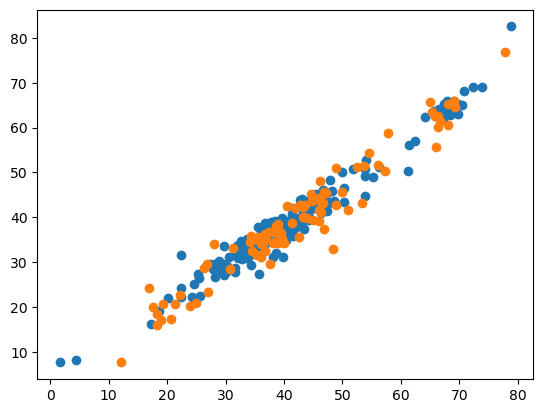

In [156]:
for scalling in ['No_scalling']:
    for set_name in ['Test']:#, ' Train']:
        for model_name in ['CNN_single_task']:
            for descriptor_name in ['Granulated']:#['DNA-Groups','Granulated','OHEP','LP_dec2']:
                for prop in ['T']:#['H', 'S', 'G', 'T']:
                    GSHT = GSHT_list[prop_list.index(prop)]
                    os.chdir('/users/qdb16186')
                    home=os.getcwd()
                    
                    p = Path('./CNN_single_task_grid/CV/')                  
                    if prop == 'T':
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}_{prop}m_10/{descriptor_name}/{prop}m/*best_grid.csv'))
                    else:
                        somelist=list(p.glob(f'**/{model_name}_{descriptor_name}_d{prop}_10/{descriptor_name}/d{prop}/*best_grid.csv'))
                    if len(somelist) ==0:
                        print('somelist is empty')
                        break

                    filter_count=0
                    for i in somelist:
                            filter_count+=1
                            df=pd.read_csv(i.resolve().absolute().as_posix())
                            plt.scatter(df.iloc[:,1], df.iloc[:,2])
                            
                            

In [155]:
df

,ID,y_true,y_pred
0,188,42.0,37.916820
1,290,40.0,37.239986
2,192,45.8,41.808280
3,224,31.9,33.078354
4,284,36.9,38.034073
...,...,...,...
208,203,53.8,44.823300
209,255,43.9,41.710487
210,72,37.9,37.820720
211,235,46.5,44.538330
